# Baseline Model

In [79]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import pandas as pd

In [81]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from tqdm import tqdm_notebook as tqdm

from functions import reduce_mem_usage
from visualize import show_transaction_nans

# Load Data

In [82]:
df_train_trans = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(), 'data', 'df_train_trans.pkl')))
df_train_id = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(), 'data', 'df_train_id.pkl')))
df_test_trans = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(), 'data', 'df_test_trans.pkl')))
df_test_id = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(), 'data', 'df_test_id.pkl')))

# Preprocess

In [8]:
print('df_train_trans.shape : ', df_train_trans.shape)
print('df_train_id.shape : ', df_train_id.shape)
print('df_test_trans : ', df_test_trans.shape)
print('df_test_id : ', df_test_id.shape)

df_train_trans.shape :  (590540, 394)
df_train_id.shape :  (144233, 41)
df_test_trans :  (506691, 393)
df_test_id :  (141907, 41)


## ID가 존재하는지 여부에 따라 3가지 데이터셋으로 구분

### ID가 있는 Transaction
- 더 많은 정보를 담고 있으므로, 더 잘 맞출것으로 예상됨
- feature수 434개 (Transaction + ID)

In [9]:
df_train_with_id = pd.merge(df_train_trans, df_train_id, on='TransactionID', how='inner')
print(df_train_with_id.shape)
display(df_train_with_id.head())
df_train_with_id.to_pickle('data/df_train_with_id.pkl')

(144233, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.875,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.500,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
df_train_with_id['id_01'].isna().sum()

0

In [11]:
df_test_with_id = pd.merge(df_test_trans, df_test_id, on='TransactionID', how='inner')
print(df_test_with_id.shape)
display(df_test_with_id.head())
df_test_with_id.to_pickle('data/df_test_with_id.pkl')

(141907, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,18404013,6.269531,C,15885,545.0,185.0,visa,138.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,18404055,50.000000,S,2453,399.0,150.0,american express,137.0,credit,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,18404235,37.312500,C,15885,545.0,185.0,visa,138.0,debit,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,18404315,6.269531,C,15885,545.0,185.0,visa,138.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,18404359,52.250000,C,9633,130.0,185.0,visa,138.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [12]:
df_test_with_id['id_01'].isna().sum()

0

In [13]:
columns_id = df_train_id.columns.drop(['TransactionID'])
print(columns_id)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')


### ID가 없는 Transaction
- 더 적은 정보를 담고 있으므로, 덜 잘 맞출것으로 예상됨
- feature수 394개 (Transaction)

In [14]:
df_train_without_id = pd.merge(df_train_trans, df_train_id, on='TransactionID', how='outer')
df_train_without_id = df_train_without_id[df_train_without_id['id_01'].isna()]
df_train_without_id = df_train_without_id.drop(columns_id, axis=1)
print(df_train_without_id.shape)
display(df_train_without_id.head())
df_train_without_id.to_pickle('data/df_train_without_id.pkl')

(446307, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_test_without_id = pd.merge(df_test_trans, df_test_id, on='TransactionID', how='outer')
df_test_without_id = df_test_without_id[df_test_without_id['id_01'].isna()]
df_test_without_id = df_test_without_id.drop(columns_id, axis=1)
print(df_test_without_id.shape)
display(df_test_without_id.head())
df_test_without_id.to_pickle('data/df_test_without_id.pkl')

(364784, 393)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Transaction 전체, ID 사용하지 않음
- 상대적으로 정보가 부족함으로, 덜 잘 맞출것으로 예상됨
- a개수 + b개수 = c개수

- df_train_trans.pkl
- df_test_trans.pkl

## Encode Categorical Variables

In [9]:
from sklearn.preprocessing import LabelEncoder

def label_encode_categorical_features(df_train, df_test) : 
    categorical_features = df_train.select_dtypes('object').columns.values
    print('\n', categorical_features)
    unseen_features = []

    for categorical_feature in categorical_features :
        df_train[categorical_feature] = df_train[categorical_feature].fillna('NaN')
        df_test[categorical_feature] = df_test[categorical_feature].fillna('NaN')  

        le = LabelEncoder()
        le.fit(df_train[categorical_feature].values)

        df_train[categorical_feature] = le.transform(df_train[categorical_feature].values)
        try : 
            df_test[categorical_feature] = le.transform(df_test[categorical_feature].values)
        except Exception as e :
            print('%s contains unseen sample from train ' % categorical_feature)
            unseen_features.append(categorical_feature)

    df_train = df_train.drop(unseen_features, axis=1)
    df_test= df_test.drop(unseen_features, axis=1)   
    
    return df_train, df_test
    

In [10]:
df_train_with_id, df_test_with_id = label_encode_categorical_features(df_train_with_id, df_test_with_id)
df_train_without_id, df_test_without_id = label_encode_categorical_features(df_train_without_id, df_test_without_id)
df_train_trans, df_test_trans = label_encode_categorical_features(df_train_trans, df_test_trans)

df_train_with_id.to_pickle('data/df_train_with_id.pkl')
df_test_with_id.to_pickle('data/df_test_with_id.pkl')
df_train_without_id.to_pickle('data/df_train_without_id.pkl')
df_test_without_id.to_pickle('data/df_test_without_id.pkl')
df_train_trans.to_pickle('data/df_train_trans.pkl')
df_test_trans.to_pickle('data/df_test_trans.pkl')


 ['ProductCD' 'card4' 'card6' 'P_emaildomain' 'R_emaildomain' 'M1' 'M2'
 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'id_12' 'id_15' 'id_16' 'id_23'
 'id_27' 'id_28' 'id_29' 'id_30' 'id_31' 'id_33' 'id_34' 'id_35' 'id_36'
 'id_37' 'id_38' 'DeviceType' 'DeviceInfo']
P_emaildomain contains unseen sample from train 
id_30 contains unseen sample from train 
id_31 contains unseen sample from train 
id_33 contains unseen sample from train 
DeviceInfo contains unseen sample from train 

 ['ProductCD' 'card4' 'card6' 'P_emaildomain' 'R_emaildomain' 'M1' 'M2'
 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9']
P_emaildomain contains unseen sample from train 
R_emaildomain contains unseen sample from train 

 ['ProductCD' 'card4' 'card6' 'P_emaildomain' 'R_emaildomain' 'M1' 'M2'
 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9']
P_emaildomain contains unseen sample from train 


## Load Dataframes

In [70]:
df_train_with_id = pd.read_pickle('data/df_train_with_id.pkl')
df_test_with_id = pd.read_pickle('data/df_test_with_id.pkl')
df_train_without_id = pd.read_pickle('data/df_train_without_id.pkl')
df_test_without_id = pd.read_pickle('data/df_test_without_id.pkl')
df_train_trans = pd.read_pickle('data/df_train_trans.pkl')
df_test_trans = pd.read_pickle('data/df_test_trans.pkl')

## Check # of NaN

In [28]:
print(df_train_with_id.shape)
print(df_test_with_id.shape)
print(df_train_without_id.shape)
print(df_test_without_id.shape)
print(df_train_trans.shape)
print(df_test_trans.shape)

(144233, 429)
(141907, 428)
(446307, 392)
(364784, 391)
(590540, 393)
(506691, 392)


### Transactions with ID

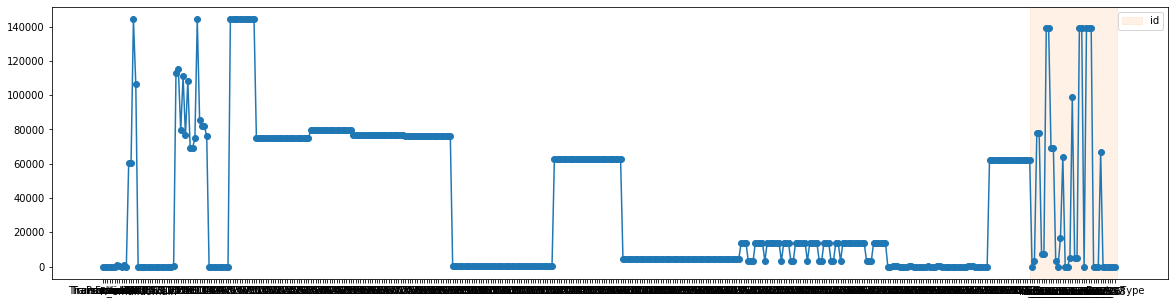

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(df_train_with_id.isna().sum(), marker='o')
plt.axvspan(df_train_without_id.shape[1], df_train_with_id.shape[1], alpha=0.1, color='tab:orange', label='id')
plt.legend()
plt.show()

### Transactions without ID

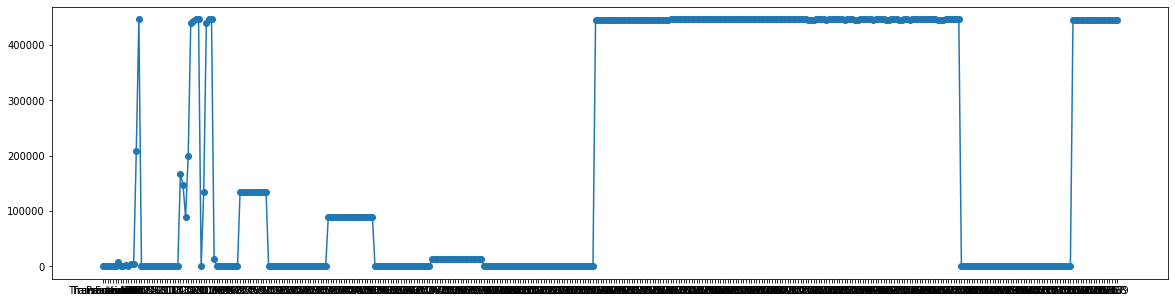

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(df_train_without_id.isna().sum(), marker='o')
plt.show()

### All Transactions without ID

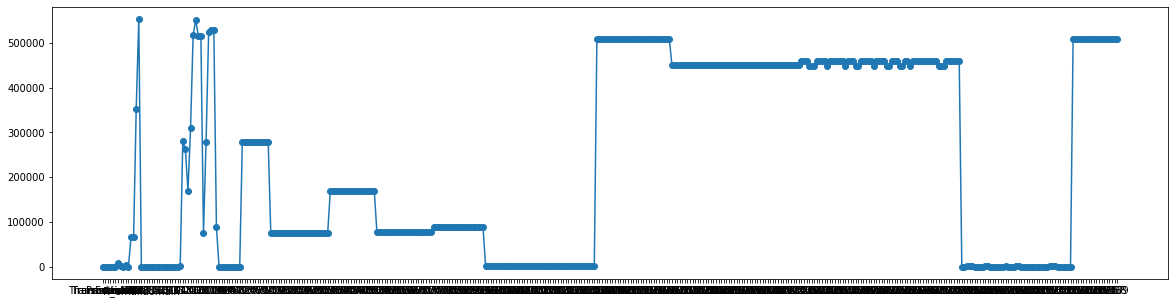

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(df_train_trans.isna().sum(), marker='o')
plt.show()

# Baseline Model with LightGBM, XGBoost, CatBoost

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from catboost import CatBoostRegressor as cat
from lightgbm import LGBMRegressor as lgbm
from xgboost import XGBRegressor as xgb
from vecstack import stacking

In [96]:
num_threads = 16

In [97]:
def pilot_run(df_train, model) :
    x = df_train_with_id.drop(['isFraud'], axis=1)
    y = df_train_with_id['isFraud']

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=False)
    print('x_train : ', x_train.shape)
    print('y_train : ', y_train.shape)
    print('x_valid : ', x_valid.shape)
    print('y_valid : ', y_valid.shape)

    model.fit(x_train, y_train)

    y_train_hat = model.predict(x_train)
    y_valid_hat = model.predict(x_valid)

    plt.figure(figsize=(10, 5))
    show_auroc(y_train, y_train_hat, 1)
    show_auroc(y_valid, y_valid_hat, 2)
    plt.show()
    return

In [98]:
def show_auroc(y, yhat, index) : 
    
    plt.subplot(1, 2, index)
    auroc = roc_auc_score(y, yhat)
    fpr, tpr, threshold = roc_curve(y, yhat)

    plt.grid()
    plt.plot([0, 1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker='.', label='AUROC=%.4f'%auroc)
    plt.legend()
    
    if index == 1 : 
        plt.title('Train Set AUROC')
    elif index == 2 :
        plt.title('Valid Set AUROC')
    return

## Transactions with ID

### Pilot Run : LGBM

x_train :  (115386, 428)
y_train :  (115386,)
x_valid :  (28847, 428)
y_valid :  (28847,)


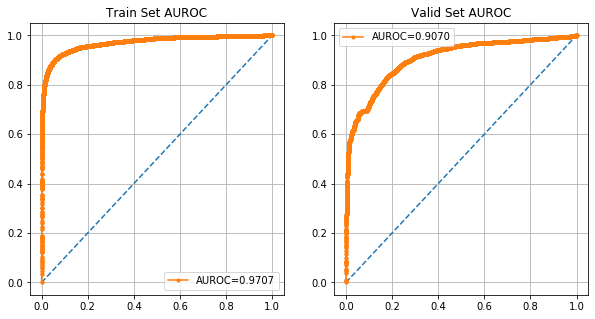

In [99]:
df_train, df_test = df_train_with_id.copy(), df_test_with_id.copy()
model = lgbm(num_threads=num_threads)
pilot_run(df_train, model)

### Pilot Run : XGBoost

x_train :  (115386, 428)
y_train :  (115386,)
x_valid :  (28847, 428)
y_valid :  (28847,)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:54:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


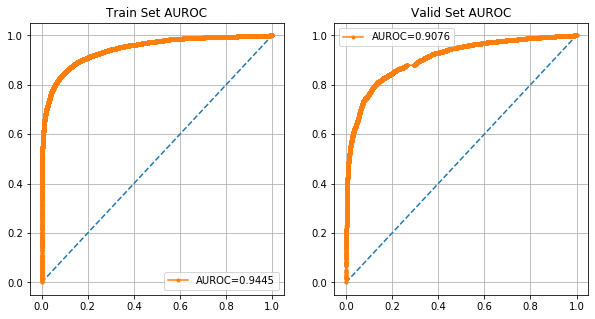

In [100]:
df_train, df_test = df_train_with_id.copy(), df_test_with_id.copy()
model = xgb(nthread=num_threads)
pilot_run(df_train, model)

### Pilot Run : CatBoost

x_train :  (115386, 428)
y_train :  (115386,)
x_valid :  (28847, 428)
y_valid :  (28847,)


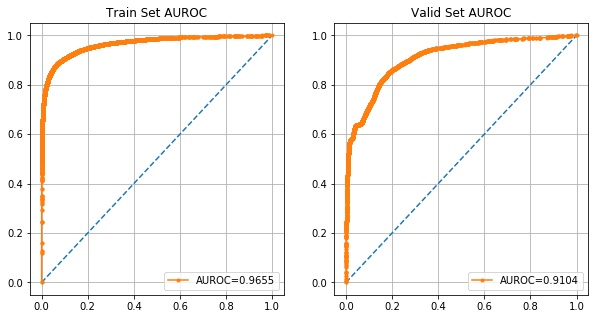

In [101]:
df_train, df_test = df_train_with_id.copy(), df_test_with_id.copy()
model = cat(thread_count=num_threads, verbose=0)
pilot_run(df_train, model)

### Stacking with NN

In [249]:
import tensorflow as tf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras_tqdm import TQDMNotebookCallback
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint

def get_train_valid(df_train) : 
    x = df_train.drop(['isFraud'], axis=1)
    y = df_train['isFraud']

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=False)

    print('x_train.shape : %s, y_train.shape : %s' % (x_train.shape, y_train.shape))
    print('x_valid.shape : %s, y_valid.shape : %s' % (x_valid.shape, y_valid.shape))

    return x_train, y_train, x_valid, y_valid

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

#### Get 1st Level Predictions from [CAT, LGBM, XGB]

In [258]:
models = [cat(thread_count=num_threads, verbose=0),
         lgbm(num_threads=num_threads),
         xgb(nthread=num_threads)]
x_train, y_train, x_valid, y_valid = get_train_valid(df_train_with_id)

x_train.shape : (115386, 428), y_train.shape : (115386,)
x_valid.shape : (28847, 428), y_valid.shape : (28847,)


In [ ]:
s_train, s_valid = stacking(models, x_train, y_train, x_valid, regression=True, verbose=2, metric=roc_auc_score)

s_train = pd.DataFrame(s_train)
s_valid = pd.DataFrame(s_valid)

s_train.to_pickle('data/s_train.pkl')
s_valid.to_pickle('data/s_valid.pkl')

In [259]:
s_train = pd.read_pickle('data/s_train.pkl')
s_valid = pd.read_pickle('data/s_valid.pkl')

print('x_train.shape : %s, y_train.shape : %s, s_train.shape : %s' % (x_train.shape, y_train.shape, s_train.shape))
print('x_valid.shape : %s, y_valid.shape : %s, s_valid.shape : %s' % (x_valid.shape, y_valid.shape, s_valid.shape))

x_train[['CAT', 'LGBM', 'XGB']] = s_train
x_valid[['CAT', 'LGBM', 'XGB']] = s_valid

x_train.shape : (115386, 428), y_train.shape : (115386,), s_train.shape : (115386, 3)
x_valid.shape : (28847, 428), y_valid.shape : (28847,), s_valid.shape : (28847, 3)


#### Train 2nd Level Model

In [260]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_train)
x_train = imp.transform(x_train)
x_valid = imp.transform(x_valid)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

y = pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True)
y = pd.get_dummies(y)
y_train_length = y_train.shape[0]
y_train = y.iloc[:y_train_length]
y_valid = y.iloc[y_train_length:]
print(y_train.shape)
print(y_valid.shape)

(115386, 2)
(28847, 2)


In [261]:
model = Sequential()
model.add(Dense(int(x_train.shape[1] * (2/3)),
               input_dim = x_train.shape[1],
               activation='relu'))
#model.add(Dense(int(x_train.shape[1] * (1/3)),
#               activation='relu'))
model.add(Dense(2, 
                activation='softmax'))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy', auc_roc])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 278)               116482    
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 558       
Total params: 117,040
Trainable params: 117,040
Non-trainable params: 0
_________________________________________________________________


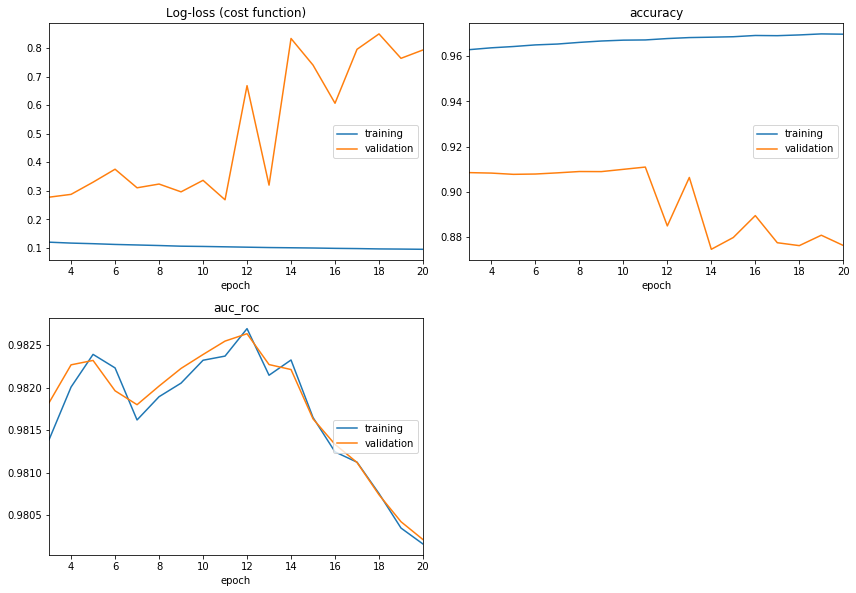

Log-loss (cost function):
training   (min:    0.096, max:    0.136, cur:    0.096)
validation (min:    0.269, max:    0.850, cur:    0.793)

accuracy:
training   (min:    0.959, max:    0.970, cur:    0.970)
validation (min:    0.874, max:    0.911, cur:    0.876)

auc_roc:
training   (min:    0.979, max:    0.983, cur:    0.980)
validation (min:    0.980, max:    0.983, cur:    0.980)



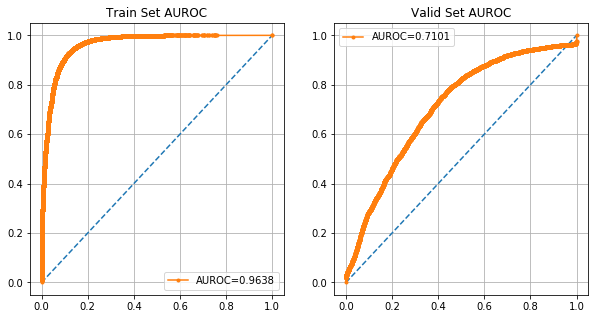

In [262]:
filepath = "model{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint('models/%s'%filepath, 
                            monitor='val_acc',
                           verbose=0,
                           save_best_only=False)

history = model.fit(x_train, y_train,
                   validation_data=(x_valid, y_valid),
                   epochs=20,
                   callbacks=[PlotLossesCallback(),
                              TQDMNotebookCallback(leave_inner=False, leave_outer=True),
                             checkpoint],
                   verbose=0)

y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

y_train_test = y_train[y_train.columns[0]]
y_train_hat_test = pd.DataFrame(y_train_hat)[pd.DataFrame(y_train_hat).columns[0]]
y_valid_test = y_valid[y_valid.columns[0]]
y_valid_hat_test = pd.DataFrame(y_valid_hat)[pd.DataFrame(y_valid_hat).columns[0]]

plt.figure(figsize=(10, 5))
show_auroc(y_train_test, y_train_hat_test, 1)
show_auroc(y_valid_test, y_valid_hat_test, 2)
plt.show()

models/model01.hdf5


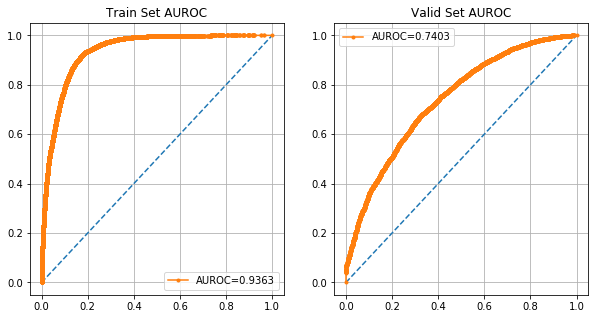

models/model02.hdf5


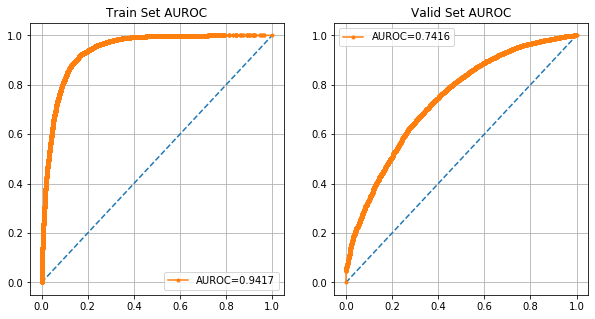

models/model03.hdf5


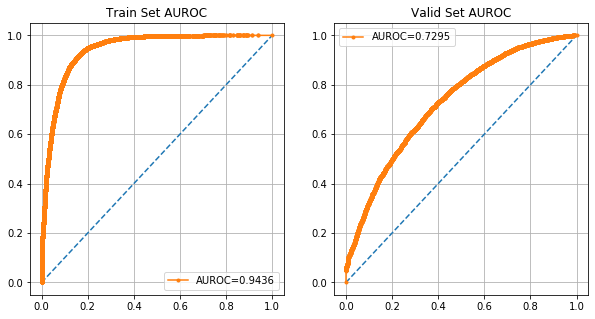

models/model04.hdf5


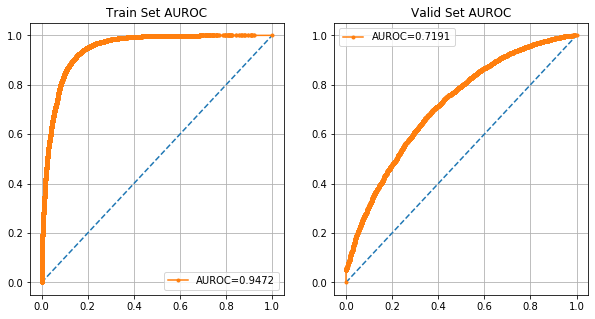

models/model05.hdf5


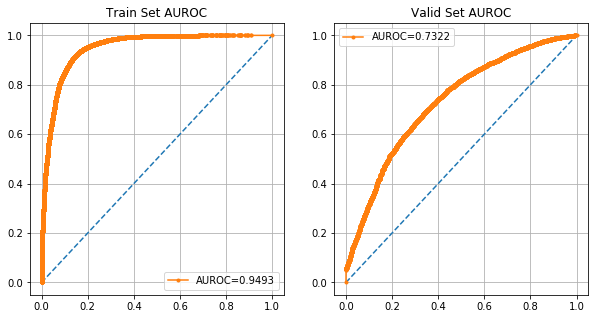

models/model06.hdf5


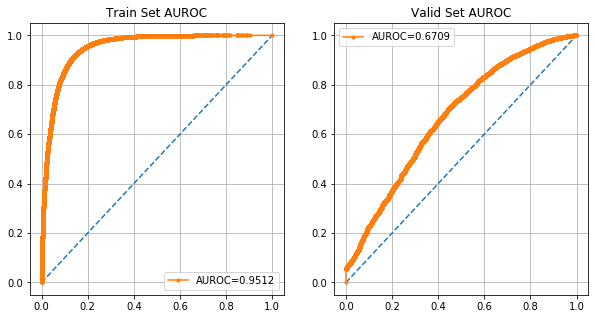

models/model07.hdf5


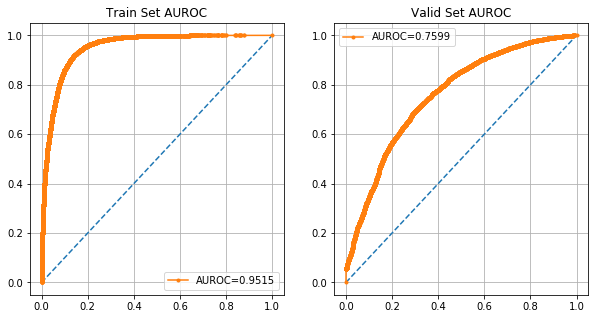

models/model08.hdf5


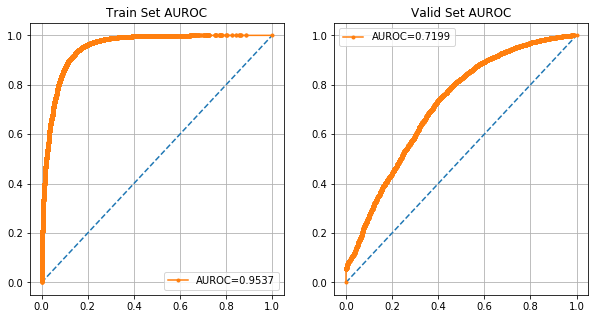

models/model09.hdf5


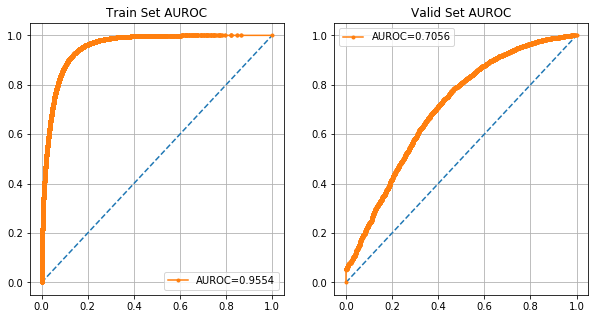

models/model10.hdf5


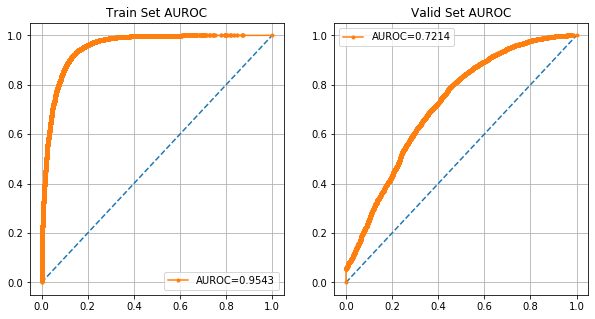

models/model11.hdf5


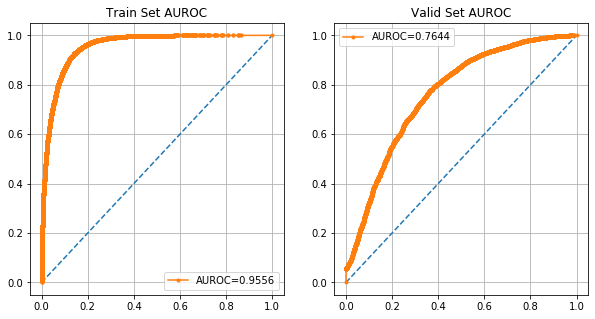

models/model12.hdf5


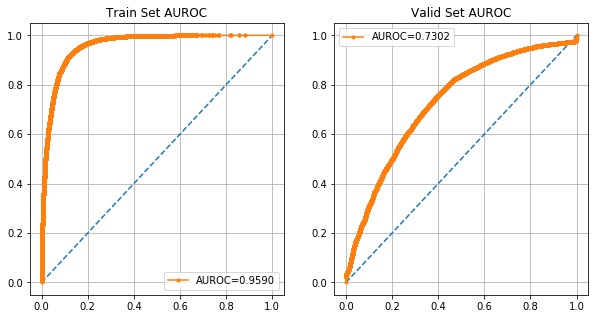

models/model13.hdf5


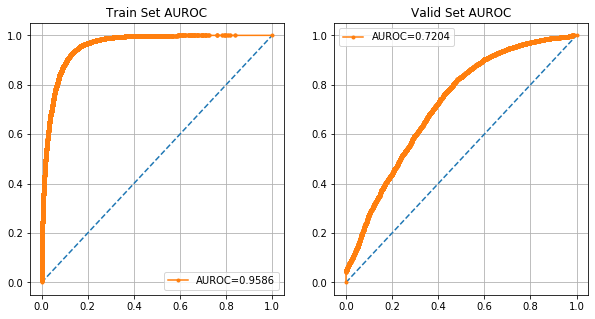

models/model14.hdf5


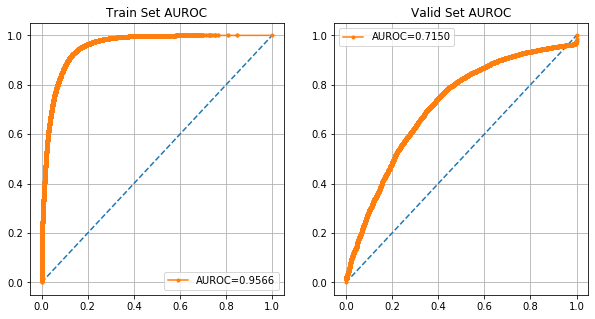

models/model15.hdf5


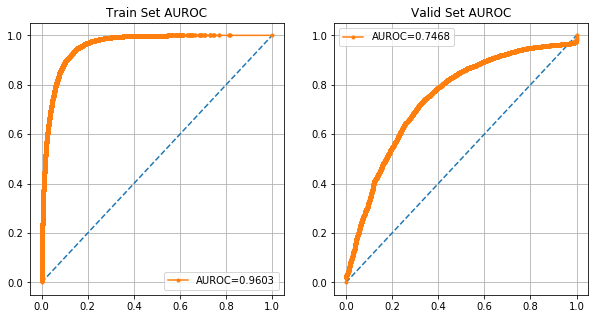

models/model16.hdf5


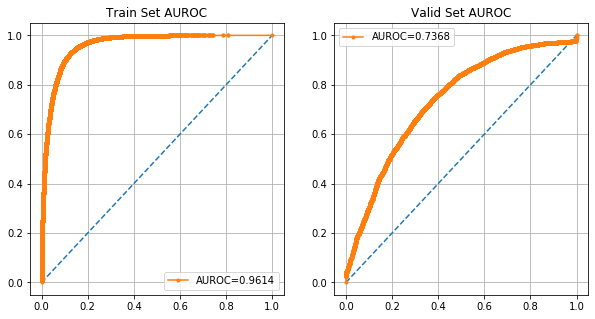

models/model17.hdf5


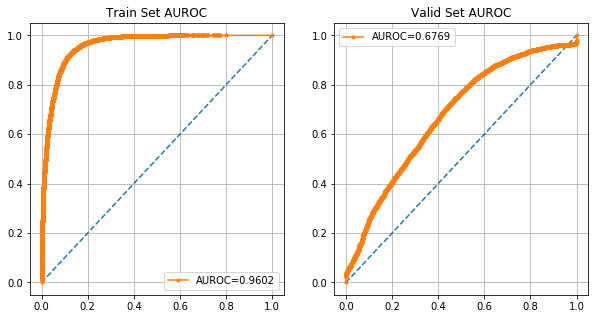

models/model18.hdf5


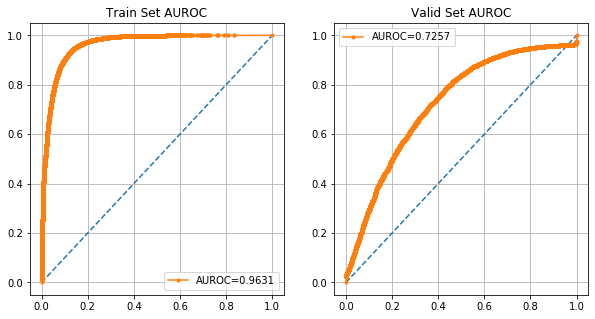

models/model19.hdf5


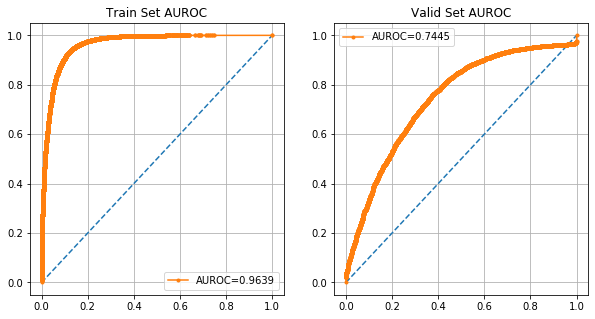

models/model20.hdf5


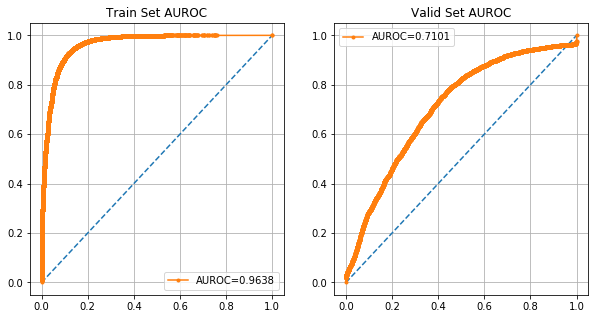

In [268]:
filelist = os.listdir('models')
filelist.sort()

for filename in filelist :
    filepath = 'models/%s' %filename
    print(filepath)
    
    model.load_weights(filepath)
    
    y_train_hat = model.predict(x_train)
    y_valid_hat = model.predict(x_valid)

    y_train_test = y_train[y_train.columns[0]]
    y_train_hat_test = pd.DataFrame(y_train_hat)[pd.DataFrame(y_train_hat).columns[0]]
    y_valid_test = y_valid[y_valid.columns[0]]
    y_valid_hat_test = pd.DataFrame(y_valid_hat)[pd.DataFrame(y_valid_hat).columns[0]]

    plt.figure(figsize=(10, 5))
    show_auroc(y_train_test, y_train_hat_test, 1)
    show_auroc(y_valid_test, y_valid_hat_test, 2)
    plt.show()

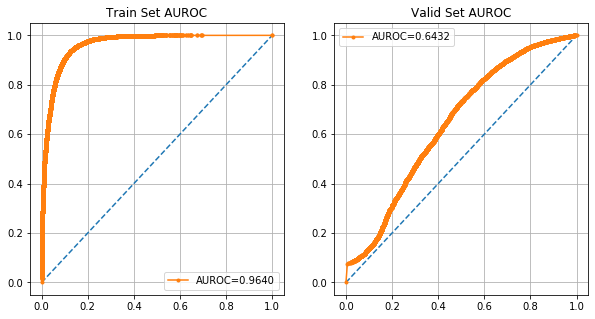

In [233]:
model_list = 

y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

y_train_test = y_train[y_train.columns[0]]
y_train_hat_test = pd.DataFrame(y_train_hat)[pd.DataFrame(y_train_hat).columns[0]]
y_valid_test = y_valid[y_valid.columns[0]]
y_valid_hat_test = pd.DataFrame(y_valid_hat)[pd.DataFrame(y_valid_hat).columns[0]]

plt.figure(figsize=(10, 5))
show_auroc(y_train_test, y_train_hat_test, 1)
show_auroc(y_valid_test, y_valid_hat_test, 2)
plt.show()

#### Stacking with XGB

In [300]:
models = [cat(thread_count=num_threads, verbose=0),
         lgbm(num_threads=num_threads),
         xgb(nthread=num_threads)]
x_train, y_train, x_valid, y_valid = get_train_valid(df_train_with_id)

s_train = pd.read_pickle('data/s_train.pkl')
s_valid = pd.read_pickle('data/s_valid.pkl')

print('x_train.shape : %s, y_train.shape : %s, s_train.shape : %s' % (x_train.shape, y_train.shape, s_train.shape))
print('x_valid.shape : %s, y_valid.shape : %s, s_valid.shape : %s' % (x_valid.shape, y_valid.shape, s_valid.shape))

x_train[['CAT', 'LGBM', 'XGB']] = s_train
x_valid[['CAT', 'LGBM', 'XGB']] = s_valid

x_train.shape : (115386, 428), y_train.shape : (115386,)
x_valid.shape : (28847, 428), y_valid.shape : (28847,)
x_train.shape : (115386, 428), y_train.shape : (115386,), s_train.shape : (115386, 3)
x_valid.shape : (28847, 428), y_valid.shape : (28847,), s_valid.shape : (28847, 3)


In [301]:
model = xgb(nthread=num_threads)
model.fit(x_train, y_train)

y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


- BatchNorm

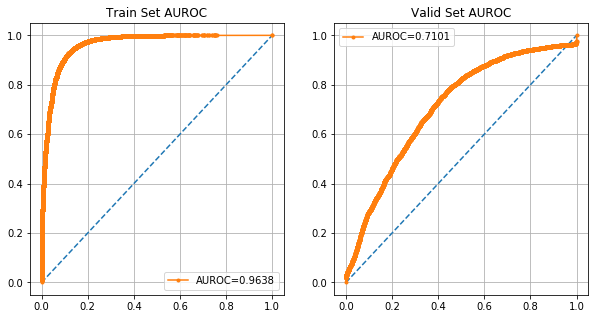

In [302]:
plt.figure(figsize=(10, 5))
show_auroc(y_train_test, y_train_hat_test, 1)
show_auroc(y_valid_test, y_valid_hat_test, 2)
plt.show()

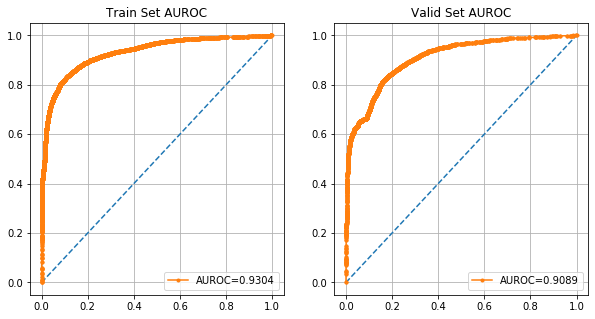

In [303]:
plt.figure(figsize=(10, 5))
show_auroc(y_train, s_train.mean(axis=1), 1)
show_auroc(y_valid, s_valid.mean(axis=1), 2)
plt.show()

# Load All Predictions